In [1]:
# Requires transformers>=4.51.0
# gpu visiableble setting
import os
import sys
def set_visible_gpus(gpu_ids):
    """
    Set the visible GPUs for the current process.
    
    Args:
        gpu_ids (str): Comma-separated string of GPU IDs to make visible.
    """
    if not isinstance(gpu_ids, str):
        raise ValueError("gpu_ids must be a string")
    
    os.environ["CUDA_VISIBLE_DEVICES"] = gpu_ids
    print(f"CUDA_VISIBLE_DEVICES set to: {gpu_ids}")

set_visible_gpus("1")

CUDA_VISIBLE_DEVICES set to: 1


In [2]:
from deepdow.data import InRAMDataset, RigidDataLoader
from deepdow.layers import SoftmaxAllocator
from deepdow.losses import MeanReturns, SharpeRatio, MaximumDrawdown
#from deepdow.layers import ConvNetwork
from deepdow.experiments import Run
from deepdow.losses import MeanReturns, SharpeRatio, MaximumDrawdown
from deepdow.benchmarks import OneOverN, InverseVolatility, Random, MinimumVariance
from deepdow.callbacks import EarlyStoppingCallback
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
from deepdow.utils import raw_to_Xy
from deepdow.benchmarks import Benchmark, OneOverN, Random, MaximumReturn
from deepdow.experiments import Run
from deepdow.callbacks import EarlyStoppingCallback, ModelCheckpointCallback, Callback
from deepdow.visualize import generate_metrics_table, generate_weights_table, plot_metrics, plot_weight_heatmap

In [3]:
use_aigc_data = True
d_model = 96
configs_dict = {
    'task_name': 'long_term_forecast',
    'features': 'M',  # or 'S' for single variable
    'seq_len': 128,
    'label_len': 0,
    'pred_len': 64,
    'use_norm': True,
    'use_aigc_data': use_aigc_data,  # whether to use AIGC data
    'patch_len': 32,
    'enc_in': (5+1024)*7,  # number of input features
    'd_model': d_model,  # model dimension
    'embed': 'fixed',  # embedding type
    'freq': 'd',  # frequency of the data
    'dropout': 0.1,
    'factor': 4,  # attention factor
    'n_heads': 8,  # number of attention heads
    'd_ff': d_model*4,  # feed-forward dimension
    'e_layers': 4,  # number of encoder layers
    'activation': 'relu',  # activation function
    #'activation': 'silu',
    'augmentation_ratio': 0,  # augmentation ratio
    'seed': 42,  #
    'loss': None,
    'batch_size': 16,  # batch size
    'reduced_channels': 256,
    'n_assets': 7,  # number of assets
}

if use_aigc_data:
    configs_dict['enc_in'] = (5+0)*7
    configs_dict['batch_size'] = 128
else:
    configs_dict['enc_in'] = 5*7


In [4]:
from flask import Config
# 把configs转换为一个类
class Configs:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

In [5]:
configs = Configs(**configs_dict)

In [6]:
from data_provider.data_loader import Dataset_Custom, custom_collate_fn
from torch.utils.data import Dataset, DataLoader
data_path = 'mag7_ticker_first_returns.parquet'
if use_aigc_data:
    aigc_data_path = 'mag7_aigc_results_embedding_reshaped.parquet'
else:
    aigc_data_path = None
train_dataset = Dataset_Custom(
    args=configs,
    root_path='.',
    flag='train',
    size=[configs.seq_len, configs.label_len, configs.pred_len],
    features=configs.features,
    data_path=data_path,
    aigc_data_path=aigc_data_path,
    target='Close',
    scale=False,
    timeenc=1,
    freq='D'
)
test_dataset = Dataset_Custom(
    args=configs,
    root_path='.',
    flag='test',
    size=[configs.seq_len, configs.label_len, configs.pred_len],
    features=configs.features,
    data_path=data_path,
    aigc_data_path=aigc_data_path,
    target='Close',
    scale=False,
    timeenc=1,
    freq='D'
)

train_dataloader = DataLoader(train_dataset, collate_fn=custom_collate_fn, batch_size=configs.batch_size, shuffle=True)
val_dataloader = DataLoader(test_dataset, collate_fn=custom_collate_fn, batch_size=configs.batch_size, shuffle=True)  

In [7]:
len(test_dataset)

32

In [8]:
for batch in val_dataloader:
    X_batch, y_batch, timestamps_batch, *kw = batch
    print("X shape:", X_batch.shape)
    print("y shape:", y_batch.shape)
    print("Timestamps:", timestamps_batch)
    #print("kw shape:", [k for k in kw])
    break  # 只打印第一个批次

X shape: torch.Size([32, 5, 128, 7])
y shape: torch.Size([32, 5, 64, 7])
Timestamps: [numpy.datetime64('2024-11-18T00:00:00.000000000'), numpy.datetime64('2024-12-20T00:00:00.000000000'), numpy.datetime64('2024-11-29T00:00:00.000000000'), numpy.datetime64('2024-12-16T00:00:00.000000000'), numpy.datetime64('2024-12-10T00:00:00.000000000'), numpy.datetime64('2024-11-26T00:00:00.000000000'), numpy.datetime64('2024-12-02T00:00:00.000000000'), numpy.datetime64('2024-12-04T00:00:00.000000000'), numpy.datetime64('2024-11-08T00:00:00.000000000'), numpy.datetime64('2024-11-22T00:00:00.000000000'), numpy.datetime64('2024-11-06T00:00:00.000000000'), numpy.datetime64('2024-12-13T00:00:00.000000000'), numpy.datetime64('2024-11-15T00:00:00.000000000'), numpy.datetime64('2024-12-17T00:00:00.000000000'), numpy.datetime64('2024-12-03T00:00:00.000000000'), numpy.datetime64('2024-12-19T00:00:00.000000000'), numpy.datetime64('2024-12-09T00:00:00.000000000'), numpy.datetime64('2024-12-18T00:00:00.000000000

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from layers.SelfAttention_Family import FullAttention, AttentionLayer
from layers.Embed import DataEmbedding_inverted, PositionalEmbedding
import numpy as np


class FlattenHead(nn.Module):
    def __init__(self, n_vars, nf, target_window, head_dropout=0):
        super().__init__()
        self.n_vars = n_vars
        self.flatten = nn.Flatten(start_dim=-2)
        self.linear = nn.Linear(nf, target_window)
        self.dropout = nn.Dropout(head_dropout)

    def forward(self, x):  # x: [bs x nvars x d_model x patch_num]
        x = self.flatten(x)
        x = self.linear(x)
        x = self.dropout(x)
        return x


class EnEmbedding(nn.Module):
    def __init__(self, n_vars, d_model, patch_len, dropout):
        super(EnEmbedding, self).__init__()
        # Patching
        self.patch_len = patch_len

        self.value_embedding = nn.Linear(patch_len, d_model, bias=False)
        self.glb_token = nn.Parameter(torch.randn(1, n_vars, 1, d_model))
        self.position_embedding = PositionalEmbedding(d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # do patching
        n_vars = x.shape[1]
        glb = self.glb_token.repeat((x.shape[0], 1, 1, 1))

        x = x.unfold(dimension=-1, size=self.patch_len, step=self.patch_len)
        x = torch.reshape(x, (x.shape[0] * x.shape[1], x.shape[2], x.shape[3]))
        # Input encoding
        x = self.value_embedding(x) + self.position_embedding(x)
        x = torch.reshape(x, (-1, n_vars, x.shape[-2], x.shape[-1]))
        x = torch.cat([x, glb], dim=2)
        x = torch.reshape(x, (x.shape[0] * x.shape[1], x.shape[2], x.shape[3]))
        return self.dropout(x), n_vars


class Encoder(nn.Module):
    def __init__(self, layers, norm_layer=None, projection=None):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList(layers)
        self.norm = norm_layer
        self.projection = projection

    def forward(self, x, cross, x_mask=None, cross_mask=None, tau=None, delta=None):
        for layer in self.layers:
            x = layer(x, cross, x_mask=x_mask, cross_mask=cross_mask, tau=tau, delta=delta)

        if self.norm is not None:
            x = self.norm(x)

        if self.projection is not None:
            x = self.projection(x)
        return x


class EncoderLayer(nn.Module):
    def __init__(self, self_attention, cross_attention, d_model, d_ff=None,
                 dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        #self.activation = F.relu if activation == "relu" elif activation == "silu" else F.gelu
        if activation == "relu":
            self.activation = F.relu
        elif activation == "silu":
            self.activation = F.silu  # PyTorch 中 SiLU 对应 F.silu
        else:
            self.activation = F.gelu

    def forward(self, x, cross, x_mask=None, cross_mask=None, tau=None, delta=None):
        B, L, D = cross.shape
        x = x + self.dropout(self.self_attention(
            x, x, x,
            attn_mask=x_mask,
            tau=tau, delta=None
        )[0])
        x = self.norm1(x)

        x_glb_ori = x[:, -1, :].unsqueeze(1)
        x_glb = torch.reshape(x_glb_ori, (B, -1, D))
        x_glb_attn = self.dropout(self.cross_attention(
            x_glb, cross, cross,
            attn_mask=cross_mask,
            tau=tau, delta=delta
        )[0])
        x_glb_attn = torch.reshape(x_glb_attn,
                                   (x_glb_attn.shape[0] * x_glb_attn.shape[1], x_glb_attn.shape[2])).unsqueeze(1)
        x_glb = x_glb_ori + x_glb_attn
        x_glb = self.norm2(x_glb)

        y = x = torch.cat([x[:, :-1, :], x_glb], dim=1)

        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))

        return self.norm3(x + y)


class Model(nn.Module, Benchmark):

    def __init__(self, configs: Configs):
        super(Model, self).__init__()
        self.task_name = configs.task_name
        self.features = configs.features
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.use_norm = configs.use_norm
        self.patch_len = configs.patch_len
        self.patch_num = int(configs.seq_len // configs.patch_len)
        self.n_vars = 1 if configs.features == 'MS' else configs.enc_in
        self.use_aigc_data = configs.use_aigc_data
        self.n_assets = configs.n_assets if hasattr(configs, 'n_assets') else 7  # 默认7个资产
        
        self.aigc_weight = nn.Parameter(torch.tensor(1.0))  # 初始化为 1.0，可根据需要调整
        # 新增：降维后的通道数
        self.reduced_channels = configs.reduced_channels if hasattr(configs, 'reduced_channels') else 1024#configs.n_channels // 2  # 默认减半
        # 新增：降维线性层
        self.channel_reduction = nn.Linear(configs.enc_in//7, self.reduced_channels)
        
        # Embedding
        self.en_embedding = EnEmbedding(self.n_vars, configs.d_model, self.patch_len, configs.dropout)

        self.ex_embedding = DataEmbedding_inverted(configs.seq_len, configs.d_model, configs.embed, configs.freq,
                                                   configs.dropout)

        self.en_aigc_embedding = nn.Linear(1024 , 5)
        self.aigc_dropout = nn.Dropout(configs.dropout)
        self.aigc_cross_dropout = nn.Dropout(configs.dropout)
        # Encoder-only architecture
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(
                        FullAttention(False, configs.factor, attention_dropout=configs.dropout,
                                      output_attention=False),
                        configs.d_model, configs.n_heads),
                    AttentionLayer(
                        FullAttention(False, configs.factor, attention_dropout=configs.dropout,
                                      output_attention=False),
                        configs.d_model, configs.n_heads),
                    configs.d_model,
                    configs.d_ff,
                    dropout=configs.dropout,
                    activation=configs.activation,
                )
                for l in range(configs.e_layers)
            ],
            norm_layer=torch.nn.LayerNorm(configs.d_model)
        )
        self.head_nf = configs.d_model * (self.patch_num + 1)
        self.head = FlattenHead(self.n_vars, self.head_nf, configs.pred_len,
                                head_dropout=configs.dropout)
        
        # layer to map dec_out to weights shape is        # [batch_size, n_assets]
        self.weight_mapping = nn.Linear(self.n_vars * configs.pred_len, 7)
        # use softmax allocator to convert weights to allocations
        self.allocator = SoftmaxAllocator(temperature=1.2)

    def forecast(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        if self.use_norm:
            # Normalization from Non-stationary Transformer
            means = x_enc.mean(1, keepdim=True).detach()
            x_enc = x_enc - means
            stdev = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5)
            x_enc /= stdev

        _, _, N = x_enc.shape

        en_embed, n_vars = self.en_embedding(x_enc[:, :, -1].unsqueeze(-1).permute(0, 2, 1))
        ex_embed = self.ex_embedding(x_enc[:, :, :-1], x_mark_enc)
        


        enc_out = self.encoder(en_embed, ex_embed)
        enc_out = torch.reshape(
            enc_out, (-1, n_vars, enc_out.shape[-2], enc_out.shape[-1]))
        # z: [bs x nvars x d_model x patch_num]
        enc_out = enc_out.permute(0, 1, 3, 2)

        dec_out = self.head(enc_out)  # z: [bs x nvars x target_window]
        dec_out = dec_out.permute(0, 2, 1)

        if self.use_norm:
            # De-Normalization from Non-stationary Transformer
            dec_out = dec_out * (stdev[:, 0, -1:].unsqueeze(1).repeat(1, self.pred_len, 1))
            dec_out = dec_out + (means[:, 0, -1:].unsqueeze(1).repeat(1, self.pred_len, 1))

        return dec_out


    def forecast_multi(self, x_enc, x_mark_enc, x_dec, x_mark_dec, x_aigc): # x_enc: [n_samples, n_channels, seq_len, n_assets] x_mark_enc: [n_samples, n_channels, seq_len, n_assets]
        if self.use_norm:
            # Normalization from Non-stationary Transformer
            means = x_enc.mean(1, keepdim=True).detach()
            x_enc = x_enc - means
            stdev = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5)
            x_enc = x_enc / stdev

        _, _, N = x_enc.shape

        en_aigc_embed = self.en_aigc_embedding(x_aigc.reshape(x_aigc.shape[0],x_aigc.shape[1],7, -1))
        en_aigc_embed = en_aigc_embed.reshape(x_aigc.shape[0],x_aigc.shape[1], -1)
        en_aigc_embed = self.aigc_dropout(en_aigc_embed)
        
        x_enc = x_enc + self.aigc_weight * en_aigc_embed
        
        en_embed, n_vars = self.en_embedding(x_enc.permute(0, 2, 1))
        
        #merge x_mark_enc and en_aigc_embed
        #x_mark_enc = torch.cat((x_mark_enc, en_aigc_embed), dim=2)
        
        ex_embed = self.ex_embedding(x_enc, x_mark_enc)
        # x_aigc = self.aigc_cross_dropout(x_aigc)
        # ex_embed = self.ex_embedding(x_enc, x_aigc)
        

        
        enc_out = self.encoder(en_embed, ex_embed)
        enc_out = torch.reshape(
            enc_out, (-1, n_vars, enc_out.shape[-2], enc_out.shape[-1]))
        # z: [bs x nvars x d_model x patch_num]
        enc_out = enc_out.permute(0, 1, 3, 2)

        dec_out = self.head(enc_out)  # z: [bs x nvars x target_window]
        dec_out = dec_out.permute(0, 2, 1)

        if self.use_norm:
            # De-Normalization from Non-stationary Transformer
            dec_out = dec_out * (stdev[:, 0, :].unsqueeze(1).repeat(1, self.pred_len, 1))
            dec_out = dec_out + (means[:, 0, :].unsqueeze(1).repeat(1, self.pred_len, 1))

        return dec_out

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec, mask=None):
        if self.use_aigc_data:
            (n_samples, n_channels, lookback, n_assets) = x_enc.shape
            x_aigc_data = x_mark_enc[:, :, 3:]
            x_mark_enc = x_mark_enc[:, :, :3]  # 保留前3个通道
        else:
            (n_samples, n_channels, lookback, n_assets) = x_enc.shape
        # 新增：对 n_channels 进行降维
        # x_enc = x_enc.permute(0, 2, 3, 1)  # [n_samples, lookback, n_assets, n_channels]
        # x_enc = self.channel_reduction(x_enc)  # [n_samples, lookback, n_assets, reduced_channels]
        # x_enc = x_enc.permute(0, 3, 1, 2)  # [n_samples, reduced_channels, lookback, n_assets]
        # 更新形状
        x_enc = x_enc.permute(0, 2, 3, 1).reshape(n_samples, lookback, n_assets * n_channels)
        (n_samples, lookback, n_mark) = x_mark_enc.shape
        if self.task_name == 'long_term_forecast' or self.task_name == 'short_term_forecast':
            if self.features == 'M':
                dec_out = self.forecast_multi(x_enc, x_mark_enc, x_dec, x_mark_dec, x_aigc_data)
                #dec_out = x_dec
                weight_out = self.weight_mapping(dec_out[:, -self.pred_len:, :].reshape(n_samples, -1))  # [B, L, D] -> [B, L * D]
                #return dec_out[:, -self.pred_len:, :]  # [B, L, D]
                dec_out = dec_out.reshape(n_samples, self.pred_len, n_assets, n_channels).permute(0,3,1,2)  # [B, L, D] -> [B, L, D]
                weights = self.allocator(weight_out)  # [B, L, D] -> [B, L, D]
                return weights, dec_out
            else:
                dec_out = self.forecast(x_enc, x_mark_enc, x_dec, x_mark_dec)
                return dec_out[:, -self.pred_len:, :]  # [B, L, D]
        else:
            return None

In [10]:
network = Model(configs)

In [11]:
loss = MaximumDrawdown(input_type='simple') + 5 * MeanReturns(input_type='simple') +  SharpeRatio(input_type='simple', rf=0.000) #+ my_loss
#loss = 5*MeanReturns(input_type='simple') + SharpeRatio(input_type='simple', rf=0.000)
configs.loss = str(loss)


In [12]:
def mse_loss(y_pred, y_true):
    """
    Calculate Mean Squared Error (MSE) loss.
    
    Args:
        y_pred (torch.tensor): Predicted values, shape (batch_size, pred_len, n_assets)
        y_true (torch.tensor): True values, shape (batch_size, pred_len, n_assets)
    
    Returns:
        float: MSE loss
    """
    squared_diff = (y_pred - y_true) ** 2
    mse = torch.mean(squared_diff)
    return mse

In [13]:
import time
from deepdow.experiments import Run, SolverError, EarlyStoppingException
from numpy import NaN

class ExtendedRun(Run):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # 初始化可训练的损失权重参数，初始值为5.0
        # self.loss_weight = torch.nn.Parameter(torch.tensor(5.0, dtype=self.dtype, device=self.device), requires_grad=True)
        # self.optimizer.add_param_group({"params": [self.loss_weight]})

    def launch(self, n_epochs=1):
        try:
            self.network.to(device=self.device, dtype=self.dtype)
            if self.current_epoch == -1:
                self.on_train_begin(metadata={"n_epochs": n_epochs})

            for _ in range(n_epochs):
                self.current_epoch += 1
                self.on_epoch_begin(metadata={"epoch": self.current_epoch})

                for batch_ix, batch in enumerate(self.train_dataloader):
                    # 解包以支持额外变量
                    X_batch, y_batch, timestamps, asset_names, *extra = batch
                    extra_data = extra[0] if extra else None  # 处理无额外数据的情况

                    self.on_batch_begin(
                        metadata={
                            "asset_names": asset_names,
                            "batch": batch_ix,
                            "epoch": self.current_epoch,
                            "timestamps": timestamps,
                            "X_batch": X_batch,
                            "y_batch": y_batch,
                            "extra_data": extra_data,
                        }
                    )

                    X_batch, y_batch = X_batch.to(self.device).to(self.dtype), y_batch.to(self.device).to(self.dtype)
                    extra = [d.to(self.device).to(self.dtype) if isinstance(d, torch.Tensor) else d for d in extra]

                    # if extra_data is not None:
                    #     extra_data = extra_data.to(self.device).to(self.dtype)

                    self.network.train()
                    
                    X_mark = extra[0]
                    y_mark = extra[1] if len(extra) > 1 else None
                    weights, y_pred = self.network(X_batch, X_mark, y_batch, y_mark)
                    
                    y_true = y_batch[:,0,:,:]
                    #y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1], 7, -1)[:,:,:,0]  # [batch_size, pred_len, n_assets]
                    y_pred = y_pred[:,0,:,:]
                    # 如果支持，将 extra_data 传递给损失函数
                    y_true = y_true[:, -configs.pred_len:, :]
                    loss_2 = mse_loss(y_pred, y_true)
                    loss_per_sample = self.loss(weights, y_batch[:,:,-configs.pred_len:, :]) 
                    loss = loss_per_sample.mean() + 3 * loss_2
                    if torch.isnan(loss):
                        print("NaN loss encountered. Skipping this batch.")
                    #print("loss_weight is {}".format(self.loss_weight.item()))
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    self.network.eval()

                    self.on_batch_end(
                        metadata={
                            "asset_names": asset_names,
                            "batch": batch_ix,
                            "batch_loss": loss.item(),
                            "epoch": self.current_epoch,
                            "timestamps": timestamps,
                            "weights": weights,
                            "X_batch": X_batch,
                            "y_batch": y_batch,
                            "extra_data": extra_data,
                        }
                    )

                self.on_epoch_end(
                    metadata={
                        "epoch": self.current_epoch,
                        "n_epochs": n_epochs,
                    }
                )

            self.on_train_end()

        except (EarlyStoppingException, KeyboardInterrupt, SolverError) as ex:
            print("训练中断")
            time.sleep(1)
            self.on_train_interrupt(metadata={"exception": ex, "locals": locals()})

        return self.history

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
d_model = configs.d_model
n_heads = configs.n_heads
n_layers = configs.e_layers

In [15]:
#获得时间 作为文件名
from datetime import datetime
now = datetime.now()
date_time = now.strftime("%Y-%m-%d %H-%M-%S")
run = ExtendedRun(network,
          loss,
          train_dataloader,
          benchmarks={'OneOverN': OneOverN(),
                      'MaximumReturn': MaximumReturn(),
                     },
          val_dataloaders={'test': val_dataloader},
          optimizer=torch.optim.Adam(network.parameters(), amsgrad=True, lr=0.001),
          callbacks=[EarlyStoppingCallback(metric_name='loss',
                                           dataloader_name='test',
                                           patience=15),
                     ModelCheckpointCallback(folder_path=f'./models/{date_time}_d_model_{d_model}_nhead{n_heads}_num_layers{n_layers}/',
                                             dataloader_name='test',
                                             metric_name='loss')],
          device=device,
          #dtype=torch.float64,
          )

#

In [16]:
#torch.autograd.set_detect_anomaly(True)
history = run.launch(15)

model          metric  epoch  dataloader
MaximumReturn  loss    -1     test         0.511
OneOverN       loss    -1     test         0.182


Epoch 14: 100%|██████████| 36/36 [00:24<00:00,  1.50it/s, loss=-0.10354, test_loss=0.10920]


In [17]:
per_epoch_results = history.metrics.groupby(['dataloader', 'metric', 'model', 'epoch'])['value']

print(per_epoch_results.count())  # double check number of samples each epoch
print(per_epoch_results.mean())  # mean loss per epoch

dataloader  metric  model          epoch
test        loss    MaximumReturn  -1       32
                    OneOverN       -1       32
                    network         0       32
                                    1       32
                                    2       32
                                    3       32
                                    4       32
                                    5       32
                                    6       32
                                    7       32
                                    8       32
                                    9       32
                                    10      32
                                    11      32
                                    12      32
                                    13      32
                                    14      32
Name: value, dtype: int64
dataloader  metric  model          epoch
test        loss    MaximumReturn  -1      0.511
                    OneOverN       -1      0

<Axes: xlabel='epoch'>

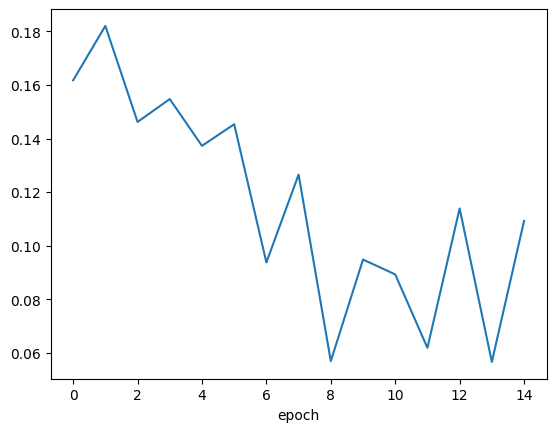

In [18]:
per_epoch_results.mean()['test']['loss']['network'].plot()

In [19]:
from json import load
import os
import glob
from pathlib import Path

def get_latest_pth_file(model_path):
    # 获取目录下所有.pth文件
    pth_files = glob.glob(os.path.join(model_path, "*.pth"))
    
    if not pth_files:
        return None  # 目录下没有.pth文件
    
    # 按修改时间排序，获取最新文件
    latest_file = max(pth_files, key=os.path.getmtime)
    return latest_file
model_path = f'./models/{date_time}_d_model_{d_model}_nhead{n_heads}_num_layers{n_layers}/'
#model_path = f'./models/2025-06-13 17-00-38_d_model_128_nhead8_num_layers5/'
#save configs to file in model_path
with open(os.path.join(model_path, 'configs.json'), 'w') as f:
    import json
    json.dump(configs.__dict__, f, indent=4)
    
#获得model_path下日期最新的文件,文件后缀是pth
best_model_file = get_latest_pth_file(model_path) #model_path + sorted(os.listdir(model_path), key=lambda x: os.path.getmtime(os.path.join(model_path, x)), reverse=True)[0]
print(f'best model file: {best_model_file}')

loaded_network = torch.load(best_model_file, weights_only=False)
loaded_network.to('cpu')
loaded_network.eval()

best model file: ./models/2025-06-18 09-05-14_d_model_96_nhead8_num_layers4/model_13__0.0565.pth


Model(
  (channel_reduction): Linear(in_features=5, out_features=256, bias=True)
  (en_embedding): EnEmbedding(
    (value_embedding): Linear(in_features=32, out_features=96, bias=False)
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (ex_embedding): DataEmbedding_inverted(
    (value_embedding): Linear(in_features=128, out_features=96, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (en_aigc_embedding): Linear(in_features=1024, out_features=5, bias=True)
  (aigc_dropout): Dropout(p=0.1, inplace=False)
  (aigc_cross_dropout): Dropout(p=0.1, inplace=False)
  (encoder): Encoder(
    (layers): ModuleList(
      (0-3): 4 x EncoderLayer(
        (self_attention): AttentionLayer(
          (inner_attention): FullAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (query_projection): Linear(in_features=96, out_features=96, bias=True)
          (key_projection): Linear(in_features=96, out_feature

In [20]:
benchmarks = {
    '1overN': OneOverN(),  # each asset has weight 1 / n_assets
    #'MaximumReturn': MaximumReturn(),  # random allocation that is however close 1OverN
    #'network': network,
    'best_network': loaded_network
}

In [21]:
metrics = {
    'MaxDD': MaximumDrawdown(),
    'Sharpe': SharpeRatio(),
    'MeanReturn': MeanReturns()
}

In [22]:
metrics_table = generate_metrics_table(benchmarks,
                                       val_dataloader,
                                       metrics,
                                       device='cpu')

In [23]:
value_1 = metrics_table[(metrics_table['metric'] == 'MeanReturn') & (metrics_table['benchmark'] == '1overN')][['value','timestamp']].sort_values('timestamp')['value']
value_2 = metrics_table[(metrics_table['metric'] == 'MeanReturn') & (metrics_table['benchmark'] == 'best_network')][['value','timestamp']].sort_values('timestamp')['value']


Text(0.5, 1.0, 'Mean Return Comparison')

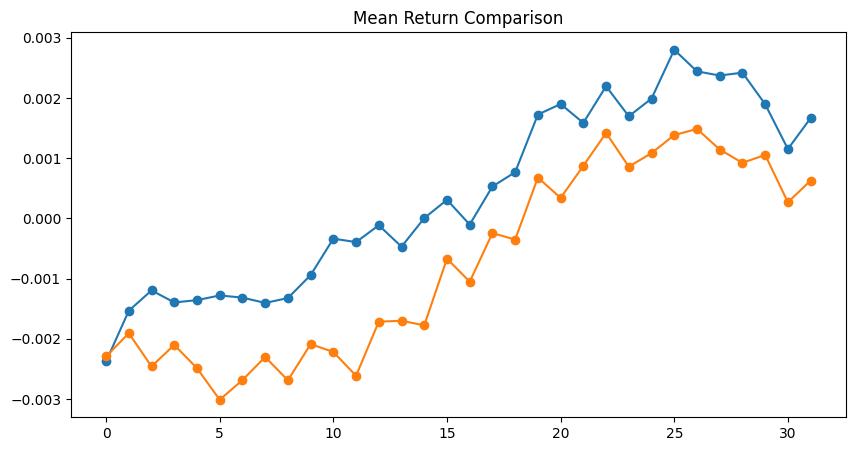

In [24]:
#plot value_1, value_2 in one plot
plt.figure(figsize=(10, 5))
plt.plot(value_1.values, label='1OverN Mean Return', marker='o')
plt.plot(value_2.values, label='Best Network Mean Return', marker='o')
plt.title('Mean Return Comparison')

array([<Axes: title={'center': 'MaxDD'}, xlabel='timestamp'>,
       <Axes: title={'center': 'Sharpe'}, xlabel='timestamp'>,
       <Axes: title={'center': 'MeanReturn'}, xlabel='timestamp'>],
      dtype=object)

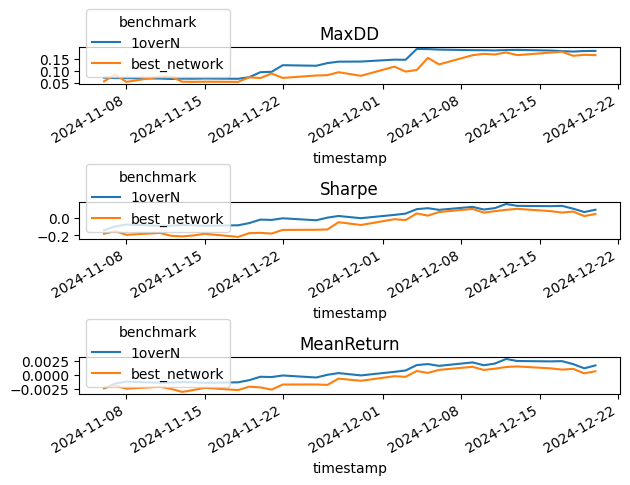

In [25]:
plot_metrics(metrics_table)

In [26]:
weight_table = generate_weights_table(loaded_network, val_dataloader,device = 'cpu')

<Axes: >

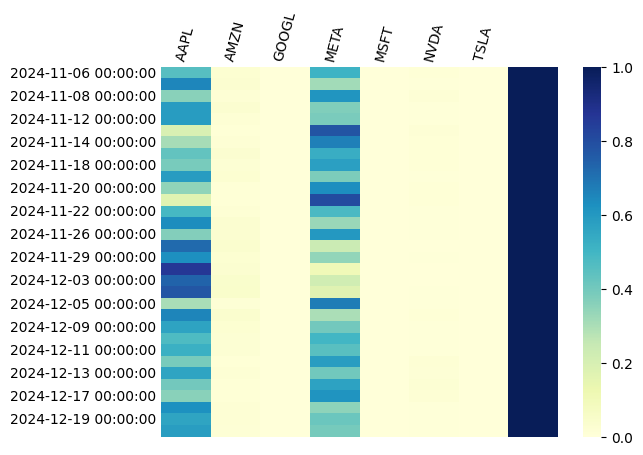

In [27]:
plot_weight_heatmap(weight_table,
                    add_sum_column=True,
                    time_format=None,
                    time_skips=2)

In [28]:
weight_table

,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA
2024-11-06,0.457,0.024,0.000,0.509,0.002,0.008,0.000
2024-11-07,0.650,0.030,0.000,0.315,0.000,0.005,0.000
2024-11-08,0.356,0.019,0.000,0.612,0.001,0.012,0.000
2024-11-11,0.588,0.030,0.000,0.373,0.001,0.008,0.000
2024-11-12,0.589,0.017,0.000,0.387,0.000,0.007,0.000
2024-11-13,0.195,0.011,0.000,0.779,0.001,0.014,0.000
2024-11-14,0.306,0.018,0.000,0.665,0.001,0.010,0.000
2024-11-15,0.431,0.028,0.000,0.528,0.002,0.010,0.000
2024-11-18,0.387,0.022,0.000,0.577,0.001,0.011,0.000
2024-11-19,0.586,0.024,0.000,0.380,0.002,0.007,0.000
